In [2]:
#Importación de paqueterias
import scipy.io as sio
from scipy.fftpack import fft
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
import glob
import matplotlib.pyplot as plt

In [3]:
#Importación de los datos
dir_datos=glob.glob('*.mat')
datos=sio.loadmat(dir_datos[0])
X=np.transpose(datos['Validation']['x'][0][0][:,:,20])
Y=np.array(np.transpose(datos['Validation']['y_logic'][0][0]),dtype=int)
dir_datos.pop(0)
for j in dir_datos:
    datos=sio.loadmat(j)
    X=np.concatenate((X,np.transpose(datos['Validation']['x'][0][0][:,:,20])),axis=0)
    Y=np.concatenate((Y,np.array(np.transpose(datos['Validation']['y_logic'][0][0]),dtype=int)),axis=0)

Los datos utilizados en este proyecto fueron descargados de la página oficial de la comptencia de Brain Computer Interface, los cuales consisten en la grabación del electroencefalograma de una persona mientras piensa en mover su mano derecha o izquerda.
Tenemos que la salida [0,1] significa que la persona pensaba en derecha y la salida [1,0] en izquierda.

In [4]:
#Aplicación de la transformada de Fourier a la serie temporal   
for i in range(np.shape(X)[0]):
    X[i,:]=np.abs(fft(X[i,:]))
#Normalización de datos
X_mean=[]
X_std=[]
for i in range(np.shape(X)[1]):
    X_mean.append(np.mean(X[:,i]))
    X_std.append(np.std(X[:,i]))
    for j in range(np.shape(X)[0]):
        X[j,i]=(X[j,i]-X_mean[i])/X_std[i]

Para el tratamiento de los datos el primer paso fue aplicar la transformada de Fourier debido a su gran utilidad para extraer la información más importante de una señal temporal. Posteriormente se realizó la normalización de los datos para evitar un overflowing en las funciones de activación de la red neuronal.

Text(0.5, 1.0, 'Visualización de datos procesados')

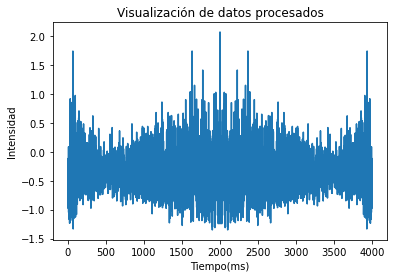

In [5]:
#Divición de los datos en entrenamiento y prueba
x_train=X[0:320,:]
y_train=Y[0:320,:]
x_test=X[320:400,:]
y_test=Y[320:400,:]
#Visualización de una serie temporal
plt.plot(x_train[0])
plt.xlabel('Tiempo(ms)')
plt.ylabel('Intensidad')
plt.title('Visualización de datos procesados')

Se dividen los datos en dos conjuntos, entrenamiento y prueba con una razón de 80% para los datos entrenamiento y 20% para los
datos de prueba. 

In [28]:
red = Sequential()
red.add(Dense(100, input_dim=4000, activation='sigmoid'))
red.add(Dense(50, activation='sigmoid'))
red.add(Dense(2,activation='sigmoid'))
 
red.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])
 
red.fit(x_train, y_train, epochs=800)

#Evaluamos el modelo
scores = red.evaluate(x_train, y_train)
print(scores)

Epoch 1/800
10/10 [==============================] - 1s 13ms/step - loss: 0.7140 - binary_accuracy: 0.5375
Epoch 2/800
10/10 [==============================] - 0s 12ms/step - loss: 0.6709 - binary_accuracy: 0.5766
Epoch 3/800
10/10 [==============================] - 0s 11ms/step - loss: 0.6274 - binary_accuracy: 0.7672
Epoch 4/800
10/10 [==============================] - 0s 13ms/step - loss: 0.5719 - binary_accuracy: 0.8734
Epoch 5/800
10/10 [==============================] - 0s 11ms/step - loss: 0.5124 - binary_accuracy: 0.8391
Epoch 6/800
10/10 [==============================] - 0s 11ms/step - loss: 0.4275 - binary_accuracy: 0.9000
Epoch 7/800
10/10 [==============================] - 0s 12ms/step - loss: 0.3259 - binary_accuracy: 0.9703
Epoch 8/800
10/10 [==============================] - 0s 11ms/step - loss: 0.2394 - binary_accuracy: 0.9859
Epoch 9/800
10/10 [==============================] - 0s 14ms/step - loss: 0.1629 - binary_accuracy: 1.0000
Epoch 10/800
10/10 [=================

Se define la red neuronal con 4 capas: capa de entrada, dos capas ocultas y una de salida. Para la función de costo utilizamos el error cuadrático medio, y para la precisión buscamos el método binario debido al tipo de salida de los datos. Finalmente entrenamos la red durante 800 épocas.

In [29]:
valores=red.predict(x_test).round()
buenas=0
for k in range(np.shape(valores)[0]):
    if np.argmax(y_test[k])==np.argmax(valores[k]):
        buenas+=1
print('Número de predecciones acertadas:',buenas,'Precisión de:',buenas*100/np.shape(y_test)[0],'%')

3/3 [==============================] - 0s 8ms/step
Número de predecciones acertadas: 48 Precisión de: 60.0 %


Una vez que la red fue entrenada se procede a revisar su eficacia con datos que no ha visto antes y se obtiene su precisión.